In [1]:
import numpy as np
#from pylab import *
from uncertainties import unumpy as unp
from uncertainties import ufloat
%pylab inline
from pprint import pprint # we use this to pretty print some stuff later

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from autograd import grad
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def func_iminuit(x, parameter): # define some function. 
    y = parameter[0]*x**3 + parameter[1]*x+ parameter[2]
    return y
# in case you want to use something like np.exp, you need to use autograd.numpy
# so autograd can still calculate the derivative
# import autograd.numpy as anp -> anp.exp()

grad_func = grad(func_iminuit) # define the derivative

In [3]:
# generate Data
num = 30 # number of data points
data_x = np.linspace(-3,2,num)
data_y = func_iminuit(data_x,[-2.0,7.0,-10])

# define some uncertainties
# in this case, we use scalar ones
xerr = sigma_x = 0.1
yerr = sigma_y = 2.0

# the uncertainties can be an array with the same length as the data as well
# xerr = np.random.normal(sigma_x,scale=sigma_x, size=num)
# yerr = np.random.normal(sigma_y,scale=sigma_y, size=num)
# xerr[xerr<0] = 2*sigma_x-xerr[xerr<0]
# yerr[yerr<0] = 2*sigma_y-yerr[yerr<0]

# add some Noise
data_x += np.random.normal(0,scale=sigma_x, size=num)
data_y += np.random.normal(0,scale=sigma_y, size=num)

# some array for the derivative values
xgrad = np.zeros(num)

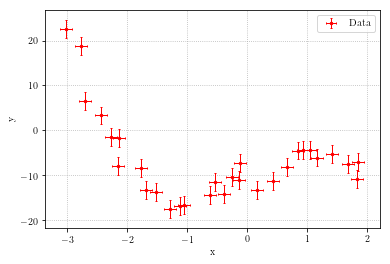

In [4]:
#Plot the Data
plt.errorbar(data_x,data_y,xerr=xerr,yerr=yerr,fmt='r.', label='Data')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
# define the squared Residuals, in which par are the parameters of the fit
# the usual one would be:
#
# def least_squares(par):
#     mu = func_iminuit(data_x, par)
#     yvar = yerr**2
#     return sum((data_y - mu) ** 2 / yvar)
# 
# here the uncertainty of x, which is stored in xerr is taken into account,
# by using gaussian error propagation with the current fit parameters
def least_squares(par):
    mu = func_iminuit(data_x, par)
    yvar = yerr**2
    xvar = xerr**2
    for i in range(len(data_x)):
        xgrad[i] = grad_func(data_x[i],par)
    complete_y_variance = yvar + xgrad**2 * xvar
    return sum((data_y - mu) ** 2 / complete_y_variance)

In [6]:
#Initialize Minuit
m = Minuit.from_array_func(least_squares,(-3.5,6,-1.5), error=(0.35,0.6,0.15), errordef=1) 
# Define some starting values for your parameters
# Define some step sizes
# 10% of the initial value seems to be alright
# Specify the errordef, which can be the negative log-likelihood or the least-squares function.
# error_def = 1 for least-squares
# If you dont have a clue about your parameters, you can set up a quick and silent guess
# m = Minuit(least_squares, pedantic=False)
# if you want to name your parameters, use name=("a", "b", "c") as optional argument

In [7]:
m.get_param_states() # prints the actual state of the parameters

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   -3.5    |    0.3    |            |            |         |         |       |
| 1 | x1   |    6.0    |    0.6    |            |            |         |         |       |
| 2 | x2   |   -1.50   |    0.15   |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [8]:
m.migrad() # actual fit

------------------------------------------------------------------
| FCN = 26.05                   |      Ncalls=86 (86 total)      |
| EDM = 4.47E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   -2.15   |    0.16   |            |            |         |         |       |
| 1 | x1   |    7.5    |    0.6    |            |            |         |         |       |
| 2 | x2   |   -10.4   |    0.4    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [9]:
pprint(m.get_fmin())
# print some information. in case "is_valid" is False, fit did not converge
# for parameter uncertainties:
# - has_covariance, has_accurate_covar, and has_posdef_covar have to be true.
# - has_made_posdef_covar and hesse_failed have to be false.

FMin(fval=26.051985211198925, edm=4.4696973096956164e-05, tolerance=0.1, nfcn=86, ncalls=86, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False)


In [10]:
pprint(m.get_param_states())
# print data of the parameters

[Param(number=0, name='x0', value=-2.145393263168541, error=0.16062387608647538, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None),
 Param(number=1, name='x1', value=7.479553284357352, error=0.6417782196856722, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None),
 Param(number=2, name='x2', value=-10.389909098645777, error=0.4357552313089334, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)]


In [11]:
print(m.fval / (len(data_y) - len(m.np_values())))  # reduced chi2, should be one for a good fit

0.9648883411555157


In [12]:
# some points on the fit function to plot it
xn = np.linspace(-3.2,2.2,100)
yn = func_iminuit(xn,m.np_values())

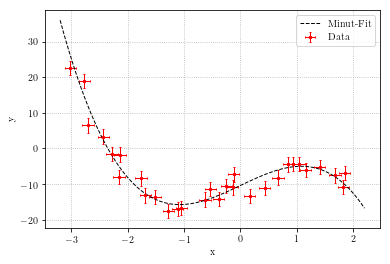

In [13]:
plt.errorbar(data_x,data_y,xerr=xerr,yerr=yerr,fmt='r.', label='Data')
plt.plot(xn,yn,'--',label='Minut-Fit')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
#plt.savefig('iminuit.pdf')

In [14]:
m.matrix(correlation=True) # shows correlation between parameters calculated with Hesse

--------------------------
|    |    x0    x1    x2 |
--------------------------
| x0 |  1.00 -0.85  0.22 |
| x1 | -0.85  1.00 -0.11 |
| x2 |  0.22 -0.11  1.00 |
--------------------------

In [15]:
m.minos() # shows correlation between parameters calculated with Minos

-------------------------------------------------
|       x0        |            Valid            |
-------------------------------------------------
|      Error      |    -0.17     |     0.15     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x1        |            Valid            |
-------------------------------------------------
|      Error      |     -0.6     |      0.7     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x2        |            Valid            |
-------------------------------------------------
|      Error      |     -0.4     |      0.4     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [16]:
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   -2.15   |    0.16   |   -0.17    |    0.15    |         |         |       |
| 1 | x1   |    7.5    |    0.6    |    -0.6    |     0.7    |         |         |       |
| 2 | x2   |   -10.4   |    0.4    |    -0.4    |     0.4    |         |         |       |
------------------------------------------------------------------------------------------

-2.13+/-0.15
7.5+/-0.6
-10.4+/-0.4


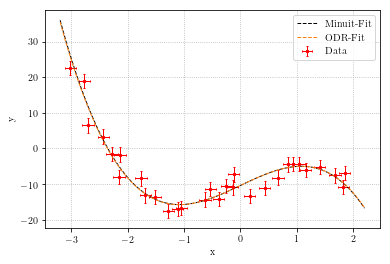

In [17]:
# some other package who deals with uncertainties is scipy.odr
from scipy.odr import ODR, Model, Data, RealData
data = RealData(data_x, data_y, xerr, yerr)

def func_odr(beta, x): # same function, just parameter and x switched around, cause odr needs it that way
    y = beta[0]*x**3 + beta[1]*x+ beta[2]
    return y

model = Model(func_odr)
odr = ODR(data, model, beta0=[-3.5,6.0,-1.5]) # same starting parameters
odr.set_job(fit_type=0) 
output = odr.run()
print(ufloat(output.beta[0], output.sd_beta[0])) # print the fit parameters of scipy.odr
print(ufloat(output.beta[1], output.sd_beta[1]))
print(ufloat(output.beta[2], output.sd_beta[2]))
plt.errorbar(data_x,data_y,xerr=xerr,yerr=yerr,fmt='r.', label='Data')
yn = func_iminuit(xn,m.np_values())
plt.plot(xn,yn,'--',label='Minuit-Fit')
yn = func_odr(output.beta, xn)
plt.plot(xn,yn,'--',label='ODR-Fit')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# plt.savefig('iminuit-vs-odr.pdf')